### Sentiment analysis on business news data

Dataset 
16840 entries of business news

in 5 categories by how negative/positive for given entity

Entity is a company name, with given location within text. Can be several entities in single article.
headline is also given.

Data is available at http://puls.cs.helsinki.fi/static/polarity/index.html
Supporting paper "Benchmarks and models for entity-oriented polarity detection" http://aclweb.org/anthology/N18-3016


#### Ppreprocess data for NNs, save it still in textual form in chosen sizes/splits as:

#### Language model training files: train, dev and test CSV under PATH LM_PATH
#### Classifier training files: train, dev and test CSV under PATH CLAS_PATH

In [ ]:
import json
import ast
import pandas as pd
import html
import numpy as np
from sklearn.model_selection import train_test_split

import sys
sys.path.append("../fastaiDL/fastai/courses/dl2")
from fastai.text import *

In [2]:
import fastai
print(getattr(fastai, '__version__', 0.6))

0.6


In [3]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
DATA = 'data/'
file = 'polarity_data.js' # business news
datafile = DATA+file

LM_PATH=Path('work/lm/')
LM_PATH.mkdir(exist_ok=True)
CLAS_PATH=Path('work/clas/')
CLAS_PATH.mkdir(exist_ok=True)
PATH=Path('.')
CLASSES = ['veryneg', 'neg', 'neut', 'pos', 'very pos']

#tags
XBOB = ' xbob ' # beginning-of-body tag
#ENTBEG = 'xentb '  # beginning-of-entity in text
#ENTEND = ' xente'  # end of entity in text
ENT =  'ENTITY '   # replace target entity in the text


In [6]:
with open(datafile, encoding='utf-8') as data_file:
    data = ast.literal_eval(data_file.read())
df = pd.DataFrame.from_dict(data, orient='columns')    

In [7]:
# extract headline start and end
df = pd.concat( [df, df['headline'].apply(pd.Series)], axis=1)

### Randomize (optional)

np.random.seed(1)
texts_idx = np.random.permutation(len(df))
df = df.iloc[texts_idx]

In [68]:
df[0:3]

,content,docnoId,end,entities,headline,start,url,content_ent,text_ent,text,label,label_binary
0,20170201\n0A21D5765ED3B8F51065D3CF7339371E\nTe...,0A21D5765ED3B8F51065D3CF7339371E,91,"{'entityId': 14123, 'name': 'Facebook', 'offse...","{'end': '91', 'start': '42'}",42,http://www.autoguide.com/auto-news/2017/02/tes...,Tesla is Now Officially More Than Just About C...,Tesla is Now Officially More Than Just About C...,Tesla is Now Officially More Than Just About C...,2,1
1,20170201\n4BBD29849EF2018A3D34932EC4AD92AB\nHe...,4BBD29849EF2018A3D34932EC4AD92AB,97,"{'entityId': 10912, 'name': 'Aetna', 'offsets'...","{'end': '97', 'start': '42'}",42,http://uk.reuters.com/article/idUKL4N1FL20C?rp...,Health insurer ENTITY Aetna's quarterly profit...,Health insurer ENTITY Aetna's quarterly profit...,Health insurer Aetna's quarterly profit beats ...,4,1
2,20170201\n80EA59EAB021503F49D4277EA2083662\nTh...,80EA59EAB021503F49D4277EA2083662,94,"{'entityId': 4054, 'name': 'Warwick Hotels & R...","{'end': '94', 'start': '42'}",42,http://feedproxy.google.com/~r/bighospitality/...,The Capital Hotel sold to American hospitality...,The Capital Hotel sold to American hospitality...,The Capital Hotel sold to American hospitality...,4,1


### Process text

### Entities

In [8]:
df.entities[0:7]

0    [{'entityId': 14123, 'name': 'Facebook', 'offs...
1    [{'entityId': 10912, 'name': 'Aetna', 'offsets...
2    [{'entityId': 4054, 'name': 'Warwick Hotels & ...
3    [{'entityId': 1897, 'name': 'Volkswagen', 'off...
4    [{'entityId': 5350, 'name': 'Volkswagen', 'off...
5    [{'entityId': 7737, 'name': 'Volkswagen', 'off...
6    [{'entityId': 5094, 'name': 'Volkswagen', 'off...
Name: entities, dtype: object

In [9]:
# articles may have several entities per single row
# example of 2 entities on same article / row, Volkswaven and Audi
df.entities[6]

[{'entityId': 5094,
  'name': 'Volkswagen',
  'offsets': [{'end': 106, 'start': 96},
   {'end': 162, 'start': 152},
   {'end': 652, 'start': 650},
   {'end': 410, 'start': 408},
   {'end': 611, 'start': 609},
   {'end': 760, 'start': 758},
   {'end': 1074, 'start': 1072},
   {'end': 1357, 'start': 1355},
   {'end': 1425, 'start': 1423}],
  'polarity': 0.0},
 {'entityId': 10458,
  'name': 'Audi',
  'offsets': [{'end': 1630, 'start': 1626}],
  'polarity': 0.0}]

In [10]:
# Notice here the documents id - docnoId. We will extract this article to 2 separate rows, 1 for each entity
df.iloc[6]

content     20161106\n2C39ABDDB47F3B7C32E9D668C6186EF2\nGe...
docnoId                      2C39ABDDB47F3B7C32E9D668C6186EF2
entities    [{'entityId': 5094, 'name': 'Volkswagen', 'off...
headline                        {'end': '125', 'start': '42'}
url         http://news.google.com/news/url?sa=t&fd=R&ct2=...
end                                                       125
start                                                      42
Name: 6, dtype: object

In [11]:
# When Pandas Dataframe column may contain list as value, unpack the list and replicate new row for each item

# https://stackoverflow.com/questions/32468402/how-to-explode-a-list-inside-a-dataframe-cell-into-separate-rows
import copy

def pandas_explode(df, column_to_explode):
    """
    Similar to Hive's EXPLODE function, take a column with iterable elements, and flatten the iterable to one element 
    per observation in the output table

    :param df: A dataframe to explod
    :type df: pandas.DataFrame
    :param column_to_explode: 
    :type column_to_explode: str
    :return: An exploded data frame
    :rtype: pandas.DataFrame
    """

    # Create a list of new observations
    new_observations = list()

    # Iterate through existing observations
    for row in df.to_dict(orient='records'):

        # Take out the exploding iterable
        explode_values = row[column_to_explode]
        del row[column_to_explode]

        # Create a new observation for every entry in the exploding iterable & add all of the other columns
        for explode_value in explode_values:

            # Deep copy existing observation
            new_observation = copy.deepcopy(row)

            # Add one (newly flattened) value from exploding iterable
            new_observation[column_to_explode] = explode_value

            # Add to the list of new observations
            new_observations.append(new_observation)

    # Create a DataFrame
    return_df = pd.DataFrame(new_observations)

    # Return
    return return_df

In [12]:
def markEntity(row):
    '''Mark entities in text by adding ENT-Tag.
    Also make entity names similar "Volkswagen", "VW" etc to single: "VW"
    '''
    
    content = row.content
    
    # a list of dictionaries type: { end, start}
    offset_list = row.entities['offsets']    
    
    # sort it from hight to low by 
    offset_list = sorted(offset_list, key=itemgetter('end'), reverse=True)
    #offset_list    
    
    # replace different forms of entity with same "Volkswagen", "VW"
    name = row.entities['name']   
    
    # for each appearance of entity
    for loc in offset_list:
        end = loc['end']
        start = loc['start']
    
        #print(end)
        #print(start)
    
        #name = content[start:end]
        #print(name)
        content = content[:start] + ENT +name + content[end:]
    return content

In [13]:
# just make entity names similar "Volkswagen", "VW", but don't add ENT tag.
def markNotEntity(row):
    '''Make entity names similar "Volkswagen", "VW" etc to single: "VW"
       No adding of ENT-tag
    '''
        
    content = row.content
    
    # a list of dictionaries type: { end, start}
    offset_list = row.entities['offsets']    
    
    # sort it from hight to low by 
    offset_list = sorted(offset_list, key=itemgetter('end'), reverse=True)
    #offset_list    
    
    # replace different forms of entity with same "Volkswagen", "VW"
    name = row.entities['name']   
    
    # for each appearance of entity
    for loc in offset_list:
        end = loc['end']
        start = loc['start']
    
        #print(end)
        #print(start)
    
        #name = content[start:end]
        #print(name)
        content = content[:start] +name + content[end:]
    return content

In [14]:
# extract entities, each to own row
print(len(df))
new = pandas_explode(df, 'entities'); print(len(new))

16840
19864


In [15]:
# we now have 2 rows with same doc. One for each entity name
new.iloc[6]

content     20161106\n2C39ABDDB47F3B7C32E9D668C6186EF2\nGe...
docnoId                      2C39ABDDB47F3B7C32E9D668C6186EF2
end                                                       125
entities    {'entityId': 5094, 'name': 'Volkswagen', 'offs...
headline                        {'end': '125', 'start': '42'}
start                                                      42
url         http://news.google.com/news/url?sa=t&fd=R&ct2=...
Name: 6, dtype: object

In [16]:
new.iloc[7]

content     20161106\n2C39ABDDB47F3B7C32E9D668C6186EF2\nGe...
docnoId                      2C39ABDDB47F3B7C32E9D668C6186EF2
end                                                       125
entities    {'entityId': 10458, 'name': 'Audi', 'offsets':...
headline                        {'end': '125', 'start': '42'}
start                                                      42
url         http://news.google.com/news/url?sa=t&fd=R&ct2=...
Name: 7, dtype: object

In [17]:
# new[new.docnoId=='2C39ABDDB47F3B7C32E9D668C6186EF2']

In [18]:
df = new

In [19]:
# Mark entities - replace target entity with ENT-tag
df['content_ent'] = df.apply(lambda row: markEntity(row), axis=1)
# cut docnoId away from beginning - first 41
df.content_ent = df.apply(lambda row: row['content_ent'][42:], axis=1)

df['text_ent'] = df['content_ent']

In [20]:
df['text'] = df.content

In [21]:
# OPTIONAL
# Only equalize entity-names - no ENT tag
#df['text'] = df.apply(lambda row: markNotEntity(row), axis=1)

In [22]:
df['text'] = df.apply(lambda row: row['text'][42:], axis=1)

In [23]:
df.text_ent[6]

'German prosecutors widen market manipulation probe to ENTITY Volkswagen chairman - Reuters\nFRANKFURT German carmaker ENTITY Volkswagen (VOWG_p.DE) said on Sunday that German prosecutors had widened an investigation into suspected market manipulation to include supervisory board Chairman Hans Dieter Poetsch.\nThe investigation, which relates to Poetsch\'s time as finance chief of ENTITY Volkswagen, is the latest fallout from the carmaker\'s admission last year that it cheated on diesel emissions tests.\nThe prosecutor\'s office in Braunschweig first announced the probe in June, targeting former ENTITY Volkswagen Chief Executive Martin Winterkorn and ENTITY Volkswagen brand chief Herbert Diess for suspected market manipulation related to the carmaker\'s emissions scandal.\nENTITY Volkswagen has admitted that it installed software that deactivated pollution controls on more than 11 million diesel vehicles sold worldwide, rattling its global business, damaging its reputation and promptin

In [24]:
df.text[6]

'German prosecutors widen market manipulation probe to Volkswagen chairman - Reuters\nFRANKFURT German carmaker Volkswagen (VOWG_p.DE) said on Sunday that German prosecutors had widened an investigation into suspected market manipulation to include supervisory board Chairman Hans Dieter Poetsch.\nThe investigation, which relates to Poetsch\'s time as finance chief of VW, is the latest fallout from the carmaker\'s admission last year that it cheated on diesel emissions tests.\nThe prosecutor\'s office in Braunschweig first announced the probe in June, targeting former VW Chief Executive Martin Winterkorn and VW brand chief Herbert Diess for suspected market manipulation related to the carmaker\'s emissions scandal.\nVW has admitted that it installed software that deactivated pollution controls on more than 11 million diesel vehicles sold worldwide, rattling its global business, damaging its reputation and prompting the departure of CEO Winterkorn.\nThe prosecutor\'s office said in June 

In [25]:
#extract headline
#df['newsheadline'] = df.apply(lambda row: row['content_ent'][int(row['start']):int(row['end']) + len(ENT)], axis=1)

# entity might not be in headline! then cant increase length by entity
# or could be n times
#df.iloc[2].newsheadline

# When marking entities - cut headline away, take len, process it, take len and put back. 
# Update end of headline parameter?

In [26]:
#df.iloc[100].content

In [27]:
#df.iloc[100].content_ent

In [37]:
# extract body of news article, "end" is end of headline within the text
#df['newsbody'] = df.apply(lambda row: row['content'][int(row['end'])+1:], axis=1) # +1 index is to skip \n

# label/label of entity 
df['label'] = df.apply(lambda row: row['entities']['polarity'], axis=1)

# change labels to integers
df.loc[df.label == 1, 'label'] = 4
df.loc[df.label == 0.7, 'label'] = 3
df.loc[df.label == 0.5, 'label'] = 2
df.loc[df.label == 0.3, 'label'] = 1
df.loc[df.label == 0, 'label'] = 0
df.loc[df.label == "contradiction", 'label'] = 5

In [38]:
# add BINARY LABELS: negative vs (positive + neutral)  
# very neg and neg (0 and 1) -> 0
# 2,3 and 4 -> 1
df['label_binary'] = df.apply(lambda row: int(not(row['label']<=1)), axis=1)

In [39]:
# if label 'int' hist dont work: ValueError: num must be 1 <= num <= 0, not 1
# if numpy.int64, it works

In [40]:
type(df.iloc[0].label)

numpy.int64

In [41]:
sum(df['label']==4)

3877

In [42]:
df.head(3)

,content,docnoId,end,entities,headline,start,url,content_ent,text_ent,text,label,label_binary
0,20170201\n0A21D5765ED3B8F51065D3CF7339371E\nTe...,0A21D5765ED3B8F51065D3CF7339371E,91,"{'entityId': 14123, 'name': 'Facebook', 'offse...","{'end': '91', 'start': '42'}",42,http://www.autoguide.com/auto-news/2017/02/tes...,Tesla is Now Officially More Than Just About C...,Tesla is Now Officially More Than Just About C...,Tesla is Now Officially More Than Just About C...,2,1
1,20170201\n4BBD29849EF2018A3D34932EC4AD92AB\nHe...,4BBD29849EF2018A3D34932EC4AD92AB,97,"{'entityId': 10912, 'name': 'Aetna', 'offsets'...","{'end': '97', 'start': '42'}",42,http://uk.reuters.com/article/idUKL4N1FL20C?rp...,Health insurer ENTITY Aetna's quarterly profit...,Health insurer ENTITY Aetna's quarterly profit...,Health insurer Aetna's quarterly profit beats ...,4,1
2,20170201\n80EA59EAB021503F49D4277EA2083662\nTh...,80EA59EAB021503F49D4277EA2083662,94,"{'entityId': 4054, 'name': 'Warwick Hotels & R...","{'end': '94', 'start': '42'}",42,http://feedproxy.google.com/~r/bighospitality/...,The Capital Hotel sold to American hospitality...,The Capital Hotel sold to American hospitality...,The Capital Hotel sold to American hospitality...,4,1


### Plot distribution of classes

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f71a7d18860>]], dtype=object)

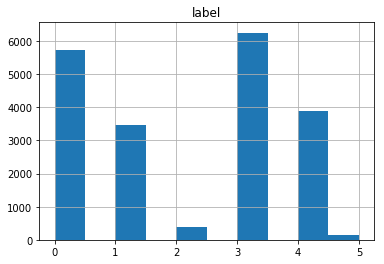

In [43]:
# if Value error, repeat label assigment above to turn field from int to to numpy.int64
df.hist(column='label')

### Plot as binary classes

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f71a83c6fd0>]], dtype=object)

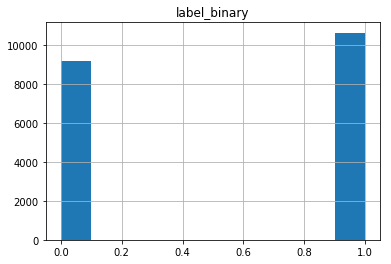

In [44]:
df.hist(column='label_binary')

In [46]:
# OBS
# 2 entities can overlap
# df.content_ent[1]
# Aetna inc : Aetna and Aetna Inc

# replacing different froms with same, becomes: insurer ENTITY Aetnatna : aetnatna
# starting same location:
#'Aetna Inc (AET.N)'
#'Aetna Inc'
df.iloc[1].entities

{'entityId': 10912,
 'name': 'Aetna',
 'offsets': [{'end': 62, 'start': 57},
  {'end': 130, 'start': 113},
  {'end': 122, 'start': 113},
  {'end': 747, 'start': 742},
  {'end': 924, 'start': 919},
  {'end': 1485, 'start': 1480},
  {'end': 1785, 'start': 1780},
  {'end': 1988, 'start': 1983},
  {'end': 2453, 'start': 2448},
  {'end': 2648, 'start': 2643},
  {'end': 2884, 'start': 2879},
  {'end': 2999, 'start': 2994},
  {'end': 3460, 'start': 3455}],
 'polarity': 1.0}

In [47]:
df.content[1][113:130]

'Aetna Inc (AET.N)'

In [48]:
df.content[1][113:122]

'Aetna Inc'

In [49]:
df.content[1]

'20170201\n4BBD29849EF2018A3D34932EC4AD92AB\nHealth insurer Aetna\'s quarterly profit beats estimates\nHealth insurer Aetna Inc (AET.N) said on Tuesday it lost more money than expected on the Obamacare individual insurance plans, one of the main pillars of the Affordable Care Act that President Donald Trump is working to "repeal and replace."\nAetna Chief Executive Officer Mark Bertolini also predicted years of transition in that individual insurance business but said it presents opportunities as new products are developed that appeal to younger and healthier people.\nBertolini said the company is weighing how to proceed after a federal court ruled last week against its $34 billion deal for Humana Inc (HUM.N) on antitrust grounds. He said Aetna, the No. 3 U.S. health insurer, may decide to appeal or there could be a deal extension, which it will announce before the current Humana agreement\'s end date of Feb. 15.\nAetna, along with UnitedHealth Group Inc (UNH.N), has largely exited the

In [50]:
def exportCSV(this_df, path, trainsize, devsize, testsize=0, desc=''):
    ''' Save train, dev and test data as CSV, with given size'''

    dev_start = trainsize
    #devsize  = 3000

    trainfile = 'train'+str(trainsize)+desc+'.csv'
    devfile = 'test_of'+str(trainsize)+desc+'.csv'
    testfile= 'final_test'+str(trainsize)+desc+'.csv'
        

    # turn into lists
    texts = this_df['text'].tolist()
    labels = this_df['label'].tolist(); assert len(texts)==len(labels)  
    
    train_texts =   texts[0:trainsize]
    train_labels = labels[0:trainsize]

    dev_texts =   texts[dev_start: dev_start+devsize]
    dev_labels = labels[dev_start: dev_start+devsize]

    if testsize >0:
        test_texts =   texts[trainsize+devsize :]
        test_labels = labels[trainsize+devsize :]
    
    
    # to DataFrame
    col_names = ['labels','text']
    df_train = pd.DataFrame({'text':train_texts, 'labels':train_labels}, columns=col_names)
    df_validate = pd.DataFrame({'text':dev_texts, 'labels':dev_labels}, columns=col_names)
    if testsize >0:
        df_test = pd.DataFrame({'text':test_texts, 'labels':test_labels}, columns=col_names)    

    # to Disk
    df_train.to_csv(path/trainfile, header=False, index=False)
    df_validate.to_csv(path/devfile, header=False, index=False)
    if testsize >0:
        df_test.to_csv(path/testfile, header=False, index=False)
    
    assert(len(train_texts)== trainsize)
    assert(len(dev_texts)== devsize)    

In [51]:
def randomize(df, seed):
    np.random.seed(seed)
    texts_idx = np.random.permutation(len(df))
    df = df.iloc[texts_idx]    
    return df

### Save Language Model data under {PATH} {LM_PATH}

In [52]:
lm_df = df.copy()
lm_df = randomize(lm_df, seed=1)
lm_df.drop_duplicates(['docnoId'], keep='first', inplace=True)
lm_df.label=0 # no labels for LM
len(lm_df)

16840

#### Truncate - optional

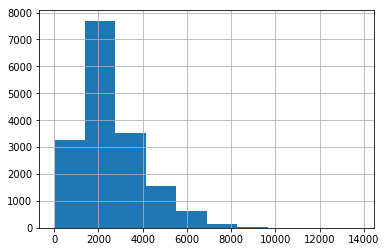

In [53]:
lm_df['text'].map(len).hist()

In [54]:
longest = lm_df['text'].map(len).max()
longest

13780

In [55]:
# Longest is 13.8k characters. From plot we see that truncating to 8k characters only cuts away minimally.

In [56]:
maxlen = 8000
lm_df['text'] = lm_df.apply(lambda row: row['text'][0:maxlen], axis=1 )
lm_df['text'].map(len).max()

8000

#### Save training data for LM, max len, from which 2000 to dev.

In [57]:
#Save training data for LM, max len, from which 2000 to dev.
# no entity marking
trnsz = len(lm_df)
exportCSV(lm_df, path=LM_PATH, trainsize=trnsz-2000, devsize=2000)  

### Save Classifier data under {PATH} {CLAS_PATH}

In [58]:
# OPTIONAL - add target entity name in start of each article
# df.newsheadline = df.apply(lambda row: row.entities['name']+' '+row['newsheadline'], axis=1)

In [59]:
cl_df = df.copy()
len(cl_df)

19864

In [60]:
# Remove label "contradictory"
contra = cl_df[cl_df['label']==5]
cl_df = cl_df[cl_df['label']!=5]

len(cl_df), len(contra)
# 16697  143

# 143 or 146???
# (19718, 146) does 146 have duplicates in it

(19718, 146)

In [61]:
cl_df.text_ent[0]

'Tesla is Now Officially More Than Just About Cars\nTesla has dropped the word “Motors” from its name.\nThe company has been working on home energy products for quite some time now, but it’s the acquisition of SolarCity Corp. that solidified the name change. Now known as just Tesla, Inc., the company is moving beyond its original goal of manufacturing electric vehicles and focusing on its role as an energy company.\nThe name change has been hinted over the last few months, with Tesla also dropping Motors from its ENTITY Facebook page as well as its official website’s URL.\nSEE ALSO: Tesla Model S Falls Short of IIHS Top Safety Pick Rating\nTesla acquired SolarCity late last year, a solar power company also founded by Elon Musk’s cousins. Musk acted as chairman of the board for SolarCity. In terms of Tesla’s energy storage products, the company unveiled its second-generation Powerwall battery storage device for home use last year, in addition to its Powerpack 2.0 commercial energy stora

### exportCSV always takes field text - not text_ent!

In [62]:
cl_df = randomize(cl_df, seed=1)
#cl_df = procData(cl_df, entity=True, truncate=4000, classifier=True)

max_len= len(cl_df) #19864
print(max_len)
dev_sz=2000
test_sz=2000

cl_df.text = cl_df.text_ent

exportCSV(cl_df,path=CLAS_PATH, trainsize=max_len-dev_sz-test_sz, devsize=2000, testsize=2000, desc="entity")

19718


In [63]:
#(CLAS_PATH/'classes.txt').open('w').writelines(f'{o}\n' for o in CLASSES)

In [64]:
#cl_df2 = procData(df, entity=False, truncate=4000, classifier=True)
#cl_df2 = randomize(cl_df2, seed=1)
#trainsizes = [16000]
#for size in trainsizes:
#    exportCSV(cl_df, path=CLAS_PATH, trainsize=size, devsize=2000, desc="noentity")